# CNN Regression Model

In [1]:
import pandas as pd
from Data_preparation_Library import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from time import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from random import choice
from scipy import signal
from pickle import load,dump
import math
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import backend as K
from pickle import dump, load

## Sample

<AxesSubplot:title={'center':'Velocity'}>

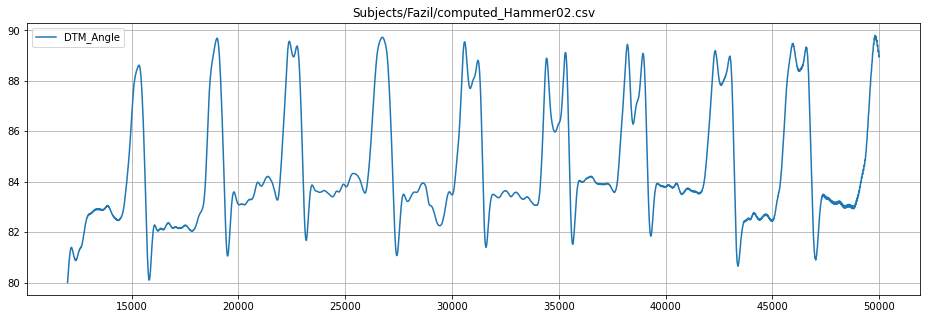

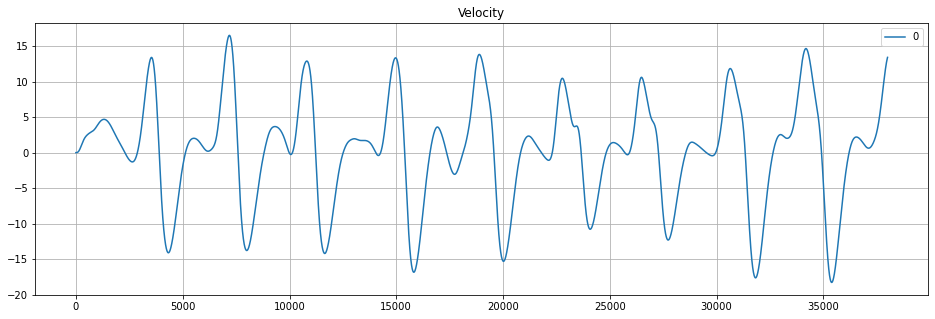

In [43]:
file = 'Subjects/Fazil/computed_Hammer02.csv'
emg_labels = ['EMG1','EMG2','EMG3','EMG4','EMG5','EMG6','EMG7','EMG8']
angle_lables = ['DTM_Angle'] # 'Pronation_Angle','Flexion_Angle',  'Radial_Angle','Elbow_Joint_Angle'
df = pd.read_csv(file,index_col=0)[12000:50000]#[32000:40000]
df[angle_lables].plot(figsize=(16,5),title=file,grid=True)

arr = np.diff([df['DTM_Angle'].values[0]]+list(df['DTM_Angle']))
arr = arr/(1/2000)
b,a = signal.butter(3, 1,fs=2000)
arr = signal.lfilter(b, a,arr)
pd.DataFrame(arr).plot(figsize=(16,5),title='Velocity',grid=True)

## Prep Data

In [67]:
window = 250

In [68]:
files = []
# subjects = ['Fazil','Nikhil','Ingy','Abhishek','Jai', 'Deepti', 'Nirmayee'] #'Fazil/day_04_14_21' ,'Varun'
subjects = ['Varun'] #'Fazil/day_04_14_21' ,'Varun'
for subj in subjects:
    path = 'Subjects/'+subj
    trial_names = ['Hammer','Cup'] # 'Bulb','Hammer' ,'Cup','Screw'
#     trial_names = ['Bulb','Screw','Hammer' ,'Cup',] #
    for exp in trial_names:
        for i in range(3):
            if(i==0):
                files.append(path+'/computed_'+exp+'.csv')
            else:
                files.append(path+'/computed_'+exp+'0'+str(i)+'.csv')
files

['Subjects/Varun/computed_Hammer.csv',
 'Subjects/Varun/computed_Hammer01.csv',
 'Subjects/Varun/computed_Hammer02.csv',
 'Subjects/Varun/computed_Cup.csv',
 'Subjects/Varun/computed_Cup01.csv',
 'Subjects/Varun/computed_Cup02.csv']

In [69]:
files_df = []
for file in files:
    files_df.append(pd.read_csv(file,index_col=0)[12000:50000])

In [70]:
files_df = filter_df(files_df)

### Remove Test Reps Data

In [4]:
test_rep_files = ['Subjects/Fazil/computed_Hammer02.csv', 
                  'Subjects/Fazil/computed_Cup02.csv']
tr_range = [32000,40000]

In [5]:
files_df = []
for file in files:
    if file in test_rep_files:
        df = pd.read_csv(file,index_col=0)[12000:50000]
        df = df.drop(df.index[tr_range[0]:tr_range[1]])
    else:
        df = pd.read_csv(file,index_col=0)[12000:50000]
    files_df.append(df)
files_df = filter_df(files_df)

### Only Removed Reps

In [41]:
files_df = []
files = test_rep_files
for file in files:
    df = pd.read_csv(file,index_col=0)
    files_df.append(df[tr_range[0]:tr_range[1]])
files_df = filter_df(files_df)

F:\The Stuffs\Awear\Final_Project\wrist_data_collection_AWEAR\Data_preparation_Library.py:467: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  files_df[i][emg_labels] = np.array(emg_df)
C:\Users\moham\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


## Rearrange

In [6]:
from collections import deque
rearr_labels = []
emg_labels = ['EMG1','EMG2','EMG3','EMG4','EMG5','EMG6','EMG7','EMG8']
labels = deque(emg_labels)
labels.rotate(1)
rearr_labels.append(list(labels))
labels.rotate(-2)
rearr_labels.append(list(labels))
rearr_labels

[['EMG8', 'EMG1', 'EMG2', 'EMG3', 'EMG4', 'EMG5', 'EMG6', 'EMG7'],
 ['EMG2', 'EMG3', 'EMG4', 'EMG5', 'EMG6', 'EMG7', 'EMG8', 'EMG1']]

In [7]:
files_df_rearrange = []
for df in tqdm(files_df):
    for lb in rearr_labels:
        df[emg_labels] = df[lb]
        files_df_rearrange.append(df) 
    
files_df = files_df+files_df_rearrange
len(files_df)

126

## Generate Training Data

In [71]:
X, y = multiple_prep_data_velocity(files_df,window,interval=10,Normalize=True,rms=False,angle_label ='DTM_Angle')
X.shape

(22650, 250, 8)

In [9]:
y = pd.Series(y.reshape((len(y)))).interpolate()

In [10]:
y.isnull().values.any()

False

In [11]:
y = y.values.reshape((len(y),1))

In [84]:
def vel_normalize(y,save=False):
#     if save == True:
#         qt = StandardScaler()
#         qt.fit(y.reshape(1,-1))
#         dump(qt, open('norm_vel_dtm.pkl', 'wb'))
#     qt = load(open('norm_vel_dtm.pkl', 'rb'))
#     yq = qt.transform(y.reshape(1,-1))
#     return yq.reshape(((-1,1)))
    y = y.reshape((len(y),))
    y_mean = y.mean()
    y_std = np.sqrt(variance(y))
    y_new = (y - y_mean)/y_std
    return y_new

## Time Window Normalize

In [31]:
X_mean = np.zeros(X[0].shape)
for x in X:
    X_mean = X_mean + x
X_mean = X_mean/X.shape[0]
X_std = np.sqrt(variance(X))
np.save('mean_std',np.array([X_mean,X_std]))

In [32]:
X_mean = np.load('mean_std_master.npy')[0]
X_std = np.load('mean_std_master.npy')[1]

In [33]:
X_new = []
for x in tqdm(X):
    X_new.append((x-X_mean)/X_std)
X = np.array(X_new)

## Test Train Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)
for data in [X_train, X_test, y_train, y_test]:
    print(data.shape)

(377640, 250, 8)
(94410, 250, 8)
(377640, 1)
(94410, 1)


In [13]:
np.save('prepared_data/X_train',X_train)
np.save('prepared_data/X_test',X_test)
np.save('prepared_data/y_train',y_train)
np.save('prepared_data/y_test',y_test)

In [103]:
X_train = np.load('prepared_data/X_train.npy')
X_test = np.load('prepared_data/X_test.npy')
y_train = np.load('prepared_data/y_train.npy')
y_test = np.load('prepared_data/y_test.npy')

In [81]:
for data in [X_train, X_test, y_train, y_test]:
    print(data.shape)

(377640, 250, 8)
(94410, 250, 8)
(377640, 1)
(94410, 1)


# Neural Network Regression

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
n_outputs = 1

In [52]:
n_outputs = 1
filter_size = 3
in_shape = (X_train.shape[1],X_train.shape[2])

model = Sequential()

model.add(Conv1D(filters=256, kernel_size=filter_size, activation='relu', input_shape=in_shape))
# model.add(Conv1D(filters=256, kernel_size=filter_size, activation='relu'))
# model.add(Conv1D(filters=256, kernel_size=filter_size, activation='relu'))
# model.add(Conv1D(filters=256, kernel_size=filter_size, activation='relu'))

model.add(Conv1D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=filter_size, activation='relu'))
# model.add(Conv1D(filters=64, kernel_size=filter_size, activation='relu'))
# model.add(Conv1D(filters=64, kernel_size=filter_size, activation='relu'))

# model.add(Dropout(0.5))

model.add(Conv1D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=filter_size, activation='relu'))
# model.add(Conv1D(filters=32, kernel_size=filter_size, activation='relu'))

# model.add(Dropout(0.5))

model.add(Conv1D(filters=16, kernel_size=filter_size, activation='relu'))
model.add(Conv1D(filters=16, kernel_size=filter_size, activation='relu'))
model.add(Conv1D(filters=16, kernel_size=filter_size, activation='relu'))
model.add(Conv1D(filters=16, kernel_size=filter_size, activation='relu'))

model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(16,activation='relu'))
model.add(Dense(8,activation='relu'))
# model.add(Dense(8,activation='relu'))

model.add(Dense(n_outputs,activation='linear'))


# model.compile(loss='mean_squared_error', optimizer='adam')
model.compile(loss='mean_squared_error', optimizer='adam',metrics=[])

checkpoint_filepath = 'best_model_reg.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='Pearson_r',
    mode='max',
    save_best_only=True)

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 248, 256)          6400      
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 246, 64)           49216     
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 244, 64)           12352     
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 242, 32)           6176      
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 240, 32)           3104      
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 238, 32)           3104      
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 236, 16)          

In [53]:
cnn_history=model.fit(X_train,y_train,epochs = 25,batch_size = 512,validation_data = (X_test,y_test),callbacks=[test_loss(X,y),model_checkpoint_callback])#

Epoch 1/25
  6/738 [..............................] - ETA: 49s - loss: 64.8734

2021-07-28 13:28:04,530 [Geometry3D WARNING] Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0241s vs `on_train_batch_end` time: 0.0456s). Check your callbacks.


738/738 [==============================] - 52s 70ms/step - loss: 42.1018 - val_loss: 34.8740
Pearson_r_Test=  0.63541
Epoch 2/25
738/738 [==============================] - 57s 77ms/step - loss: 19.2358 - val_loss: 13.0781
Pearson_r_Test=  0.85187
Epoch 3/25
738/738 [==============================] - 59s 80ms/step - loss: 11.0546 - val_loss: 13.0269
Pearson_r_Test=  0.88294
Epoch 4/25
738/738 [==============================] - 59s 80ms/step - loss: 7.6593 - val_loss: 5.9258
Pearson_r_Test=  0.90089
Epoch 5/25
738/738 [==============================] - 58s 79ms/step - loss: 5.8767 - val_loss: 4.7825
Pearson_r_Test=  0.91023
Epoch 6/25
738/738 [==============================] - 59s 80ms/step - loss: 4.8784 - val_loss: 4.5108
Pearson_r_Test=  0.90096
Epoch 7/25
738/738 [==============================] - 60s 81ms/step - loss: 4.1379 - val_loss: 6.3510
Pearson_r_Test=  0.92105
Epoch 8/25
738/738 [==============================] - 60s 81ms/step - loss: 3.7164 - val_loss: 3.4990
Pearson_r_Test

In [54]:
best_model = load_model('best_model_reg.hdf5')
best_model.save('models/dtm_velocity_model_{}.hdf5'.format(250))

In [55]:
cnn_history_df = pd.DataFrame(cnn_history.history) 
hist_csv_file = 'regression_history.csv'
with open(hist_csv_file, mode='w') as f:
    cnn_history_df.to_csv(f)

In [56]:
cnn_history_df = pd.read_csv('regression_history.csv')

<AxesSubplot:>

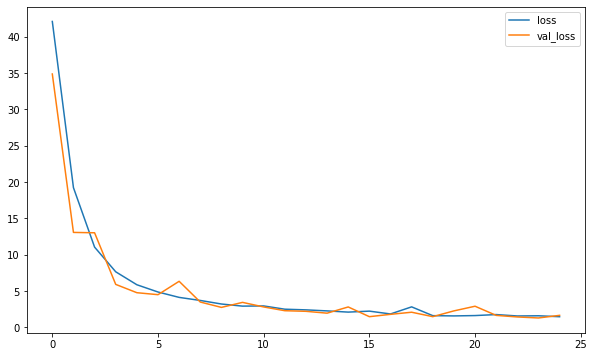

In [57]:
cnn_history_df[['loss', 'val_loss']].plot(figsize=(10,6))

<AxesSubplot:>

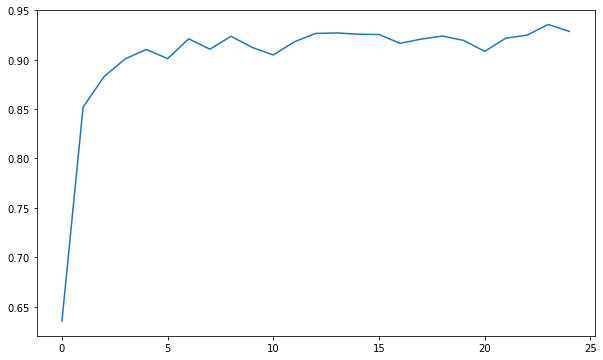

In [58]:
cnn_history_df['Pearson_r'].plot(figsize=(10,6))

## Model Testing

In [2]:
window = 250
best_model = load_model('models/dtm_velocity_model_{}.hdf5'.format(window))
# best_model = load_model('best_model_reg.hdf5')

In [3]:
file = 'Subjects/Fazil/computed_Hammer02.csv'
df = pd.read_csv(file,index_col=0)[32000:40000]
df = filter_df([df])[0]

In [4]:
X, y = prep_data_velocity(df,window,interval=10,Normalize=True,rms=False,angle_label ='DTM_Angle')

In [62]:
file = 'Subjects/Fazil/computed_Cup02.csv'
df = pd.read_csv(file,index_col=0)[32000:40000]
df = filter_df([df])[0]
X2, y2 = prep_data_velocity(df,window,interval=10,Normalize=True,rms=False,angle_label ='DTM_Angle')

In [63]:
X = np.vstack((X,X2))
y = np.vstack((y,y2))#.reshape((len(y)+len(y2),1))
print(X.shape,y.shape)

(1550, 250, 8) (1550, 1)


In [87]:
X_mean = np.load('mean_std_master.npy')[0]
X_std = np.load('mean_std_master.npy')[1]
X_new = []
for x in tqdm(X):
    X_new.append((x-X_mean)/X_std)
X = np.array(X_new)

25/25 [==============================] - 0s 4ms/step - loss: 5.3134


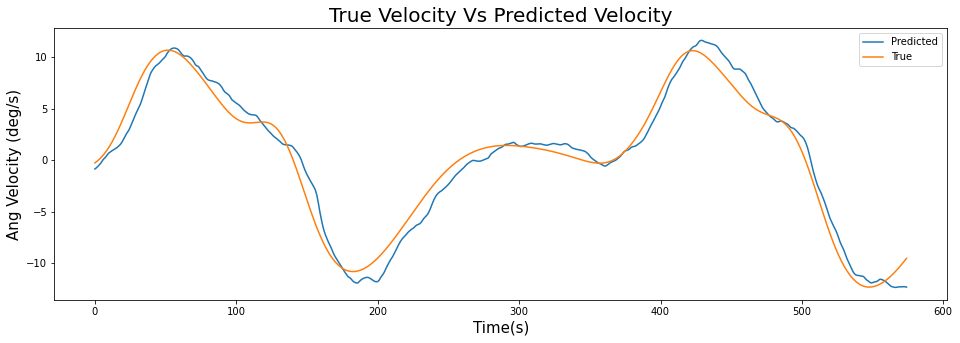

In [5]:
test_model = best_model
pred = test_model.predict(X)
test_model.evaluate(X,y)

plt.figure(figsize=(16,5))
pred = filter_array(pred,order=1,cf=50,fs=2000)
# y = filter_array(y,order=1,cf=100,fs=2000)
plt.plot(pred[200:])
plt.plot(y[200:])
plt.title('True Velocity Vs Predicted Velocity',size=20)
plt.ylabel('Ang Velocity (deg/s)',size=15)
plt.xlabel('Time(s)', size=15)
plt.legend(['Predicted', 'True'], loc='best')
plt.show()

In [6]:
df = pd.DataFrame(columns=['Predicted_velocity','True_Velocity'])
df['Predicted_velocity'] = pred[200:]
df['True_Velocity'] = y[200:]
df.to_excel('DTM_velocity_regression.xlsx')
df

,Predicted_velocity,True_Velocity
0,-0.862834,-0.273847
1,-0.757517,-0.172759
2,-0.624163,-0.060968
3,-0.468122,0.061948
4,-0.323606,0.196465
...,...,...
570,-12.298514,-10.210419
571,-12.296154,-10.044868
572,-12.277842,-9.875581
573,-12.289894,-9.702754


In [80]:
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
print('MSE Loss -',mean_squared_error(y,pred))
print('RMSE -',mean_squared_error(y,pred,squared=False))
print('Pearson Correlation Coefficient -',pearsonr(y.flatten(),pred.flatten()))

MSE Loss - 5.0603022731028435
RMSE - 2.2495115632294143
Pearson Correlation Coefficient - (0.9321433936480011, 0.0)


In [ ]:
# pearsonr 0.8

In [22]:
def correlation_coefficient_loss(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(xm * ym)
    r_den = K.sum(K.sum(K.square(xm)) * K.sum(K.square(ym)))
    r = r_num / r_den
    return 1 - r**2


def correlation_coefficient(y_true, y_pred):
    pearson_r, update_op = tf.contrib.metrics.streaming_pearson_correlation(y_pred, y_true)
    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'correlation_coefficient' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        pearson_r = tf.identity(pearson_r)
        return 1-pearson_r**2
def pearson_r(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    r_num = K.sum(xm * ym)
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = K.sqrt(x_square_sum * y_square_sum)
    r = r_num / r_den
    return K.mean(r)

In [57]:
system_sleep()

In [ ]:
system_shutdown()

In [21]:
class test_loss(tf.keras.callbacks.Callback):

    def __init__(self, X,y):
        super(test_loss, self).__init__()
        self.X_t = X
        self.y_t = y
        
    def on_epoch_end(self, epoch, logs={}):
        logs['Pearson_r'] = float('-inf')
        pred = self.model.predict(self.X_t)
        score = pearsonr(pred.flatten(),self.y_t.flatten())[0]
        logs['Pearson_r'] = np.round(score, 5)
        print('Pearson_r_Test= ',np.round(score, 5))



In [29]:
ypd = pd.Series(y.reshape((len(y)))).interpolate()

In [30]:
ypd.isnull().values.any()

False